Isolating the Transient to Speed up Training Time and hopefully Accuracy Too

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import MiniRocketMultivariateVariable
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from module import my_improved_bayesian_change_point_detection, load_data, preprocess_bluetooth_signals
from rf_classifier import RFClassifier

In [2]:
# Set the root directory
root_directory = os.path.join(os.path.join(os.getcwd(), 'Bluetooth Datasets'), 'Dataset 10 Gsps')

In [3]:
# Load the data
data = load_data(root_directory)

In [4]:
print(data.head())

                                              signal  \
0  0        0.0035
1        0.0021
2        0.004...   
1  0        0.0039
1        0.0019
2        0.003...   
2  0        0.0021
1        0.0045
2        0.001...   
3  0        0.0023
1        0.0035
2        0.001...   
4  0        0.0033
1        0.0023
2        0.003...   

                                  label  \
0  Iphone\4s\013004004984503_oguz_guler   
1  Iphone\4s\013004004984503_oguz_guler   
2  Iphone\4s\013004004984503_oguz_guler   
3  Iphone\4s\013004004984503_oguz_guler   
4  Iphone\4s\013004004984503_oguz_guler   

                                            filename  
0  013004004984503_oguz_guler_ro_iphone_4s_record...  
1  013004004984503_oguz_guler_ro_iphone_4s_record...  
2  013004004984503_oguz_guler_ro_iphone_4s_record...  
3  013004004984503_oguz_guler_ro_iphone_4s_record...  
4  013004004984503_oguz_guler_ro_iphone_4s_record...  


In [5]:
print(data['label'].value_counts())

label
Iphone\4s\013004004984503_oguz_guler              150
Iphone\4s\013051002641007_koray_oktem             150
Iphone\7\356563081643675_cuneyt_buyukkilic        150
Iphone\7\359206078179249_ismet_buyukkilic         150
Iphone\7plus\355373083202269_akin_yavuz           150
Iphone\7plus\359179071432156_melisa_topcu         150
Lg\V20\3521162080037221_ozan_erbasan              150
Lg\V20\352162080046735_melis_yilmaz               150
Samsung\J7\352952078845142_omerfaruk_altuntas     150
Samsung\J7\359947076663425_onder_sahin            150
Samsung\Note2\355056057465265_yesim_balci         150
Samsung\S7edge\357220078785725_melisa_oktem       150
Xiaomi\Mi6\867391032321064_berat_serefoglu        150
Xiaomi\Mi6\864890030385966_umut_erkan             150
Samsung\Note2\356261053336200_ismet_buyukkilic    149
Samsung\S7edge\359948079357437_baris_ozgunduz     149
Name: count, dtype: int64


New Section: Preprocess data by removing spur signals, normalizing, applying hilbert transform, and isolating transient

In [6]:
preprocessed_data = preprocess_bluetooth_signals(data, signal_column='signal', dataset='B')

Preprocessing 2398 signals from dataset B...
Processing signal 1/2398...
Processing signal 1001/2398...
Processing signal 2001/2398...
Preprocessing complete!


In [7]:
preprocessed_data['transient'] = None
for idx, row in preprocessed_data.iterrows():
    analytic_signal = row['analytic_signal']
    start_idx, end_idx, _, _ = my_improved_bayesian_change_point_detection(analytic_signal, window_size=1200, overlap=0.65, start_threshold=10)
    preprocessed_data.at[idx, 'transient'] = analytic_signal[start_idx:end_idx]

In [8]:
for idx, row in preprocessed_data.iterrows():
    print(f'Length of original signal: {len(row['signal'])}')
    print(f'Type of original signal: {type(row['signal'])}')
    print(f'Length of filtered signal: {len(row['filtered_signal'])}')
    print(f'Type of filtered signal: {type(row['filtered_signal'])}')
    print(f'Length of normalized signal: {len(row['normalized_signal'])}')
    print(f'Type of normalized signal: {type(row['normalized_signal'])}')
    print(f'Length of analytic signal: {len(row['analytic_signal'])}')
    print(f'Type of analytic signal: {type(row['analytic_signal'])}')
    print(f'Length of I data: {len(row['I_data'])}')
    print(f'Type of I data: {type(row['I_data'])}')
    print(f'Length of Q data: {len(row['Q_data'])}')
    print(f'Type of Q data: {type(row['Q_data'])}')
    print(f'Length of transient: {len(row['transient'])}')
    print(f'Type of transient: {type(row['transient'])}')
    break

Length of original signal: 74001
Type of original signal: <class 'pandas.core.series.Series'>
Length of filtered signal: 70301
Type of filtered signal: <class 'numpy.ndarray'>
Length of normalized signal: 70301
Type of normalized signal: <class 'numpy.ndarray'>
Length of analytic signal: 70301
Type of analytic signal: <class 'numpy.ndarray'>
Length of I data: 70301
Type of I data: <class 'numpy.ndarray'>
Length of Q data: 70301
Type of Q data: <class 'numpy.ndarray'>
Length of transient: 11340
Type of transient: <class 'numpy.ndarray'>


In [9]:
def extract_transient_features(transient, fs):
    """Extract 9 HOS features + duration from a transient signal"""
    # Convert pandas Series to numpy array
    analytic = transient
    
    # Compute analytic signal
    # analytic = hilbert(signal)
    
    # Instantaneous characteristics
    amplitude = np.abs(analytic)
    amplitude_centered = amplitude - np.mean(amplitude)

    phase = np.unwrap(np.angle(analytic))
    time = 1 / fs
    mu_f = np.mean(np.diff(phase)/(2 * np.pi))  # Mean frequency
    phase_nonlinear = phase - 2 * np.pi * mu_f * time
    phase_centered = phase_nonlinear - np.mean(phase_nonlinear)

    frequency = np.diff(phase)/(2*np.pi)  # Handle length mismatch
    frequency_centered = frequency - np.mean(frequency)
    
    # Calculate HOS features
    features = {
        'amp_var': np.var(amplitude_centered),
        'amp_skew': skew(amplitude_centered, bias=False),
        'amp_kurt': kurtosis(amplitude_centered, fisher=True, bias=False),
        'phase_var': np.var(phase_centered),
        'phase_skew': skew(phase_centered, bias=False),
        'phase_kurt': kurtosis(phase_centered, fisher=True, bias=False),
        'freq_var': np.var(frequency_centered) if len(frequency) > 0 else 0,
        'freq_skew': skew(frequency_centered, bias=False) if len(frequency) > 0 else 0,
        'freq_kurt': kurtosis(frequency_centered, fisher=True, bias=False) if len(frequency) > 0 else 0,
        'duration': len(analytic)
    }
    
    return features

In [10]:
# Normalize and center features
def normalize_features(df):
    """Z-score normalization for all feature columns"""
    normalized_df = df.copy()
    for col in normalized_df.columns:
        if col != 'duration':
            mean = normalized_df[col].mean()
            std = normalized_df[col].std()
            normalized_df[col] = (normalized_df[col] - mean)/std
    return normalized_df

In [11]:
# Extract features for all transients
# feature_df = preprocessed_data['transient'].apply(extract_transient_features).apply(pd.Series)
feature_df = preprocessed_data['transient'].apply(
    lambda x: extract_transient_features(x, fs=10e9)
).apply(pd.Series)

In [12]:
feature_df.head()

,amp_var,amp_skew,amp_kurt,phase_var,phase_skew,phase_kurt,freq_var,freq_skew,freq_kurt,duration
0,0.114549,-0.251747,-1.492340,2.549563e+07,0.000046,-1.200031,4.297038e-07,3.013040,35.342679,11340.0
1,0.108091,-0.044457,-1.542281,2.143322e+07,0.000049,-1.200027,2.128101e-07,-0.606355,16.839173,10500.0
2,0.101028,-0.123554,-1.497603,1.814112e+07,0.000030,-1.200013,1.014082e-07,-1.400040,29.137783,9660.0
3,0.103713,-0.075646,-1.519126,1.785881e+07,0.000044,-1.200022,1.297633e-07,-0.665260,9.935360,9660.0
4,0.111366,-0.063524,-1.561738,2.360426e+07,0.000042,-1.200032,5.677758e-07,4.565198,50.090851,10920.0


In [13]:
# Apply normalization (excluding duration initially)
normalized_features = normalize_features(feature_df)

In [14]:
# Normalize duration separately
duration_mean = feature_df['duration'].mean()
duration_std = feature_df['duration'].std()
normalized_features['duration'] = (feature_df['duration'] - duration_mean)/duration_std

In [15]:
for col in normalized_features.columns:
    q1 = normalized_features[col].quantile(0.25)
    q3 = normalized_features[col].quantile(0.75)
    iqr = q3 - q1
    # outliers = normalized_features[(normalized_features[col] < (q1 - 1.5*iqr)) | (normalized_features[col] > (q3 + 1.5*iqr))]
    outliers = normalized_features[(normalized_features[col] < -3) | (normalized_features[col] > 3)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(normalized_features):.1%})")

amp_var: 4 outliers (0.2%)
amp_skew: 12 outliers (0.5%)
amp_kurt: 48 outliers (2.0%)
phase_var: 77 outliers (3.2%)
phase_skew: 51 outliers (2.1%)
phase_kurt: 53 outliers (2.2%)
freq_var: 39 outliers (1.6%)
freq_skew: 76 outliers (3.2%)
freq_kurt: 57 outliers (2.4%)
duration: 68 outliers (2.8%)


In [16]:
clipped_features = normalized_features.copy()

# Clip features between -3 and 3 (z-score units)
for col in clipped_features.columns:
    clipped_features[col] = np.clip(clipped_features[col], -3.5, 3.5)

# Add normalized features back to original dataframe
# complete_df = pd.concat([preprocessed_data, normalized_features], axis=1)
complete_df = pd.concat([preprocessed_data, clipped_features], axis=1)

In [17]:
preprocessed_data.head()

,signal,label,filename,filtered_signal,normalized_signal,analytic_signal,I_data,Q_data,transient
0,0 0.0035 1 0.0021 2 0.004...,Iphone\4s\013004004984503_oguz_guler,013004004984503_oguz_guler_ro_iphone_4s_record...,"[1.4530537899018204e-05, 3.152383494460062e-05...","[0.003675272541188227, 0.007973461531157001, -...","[(0.00367527254118819-0.3088209019854309j), (0...","[0.00367527254118819, 0.007973461531157074, -0...","[-0.3088209019854309, 0.1006619132058073, -0.0...","[(0.022354140126480578+0.007640374221223357j),..."
1,0 0.0039 1 0.0019 2 0.003...,Iphone\4s\013004004984503_oguz_guler,013004004984503_oguz_guler_ro_iphone_4s_record...,"[1.662943702275284e-05, -2.6273821287584196e-0...","[0.004024434297083603, -0.006358439396386452, ...","[(0.004024434297083448+0.44494557981805255j), ...","[0.004024434297083448, -0.00635843939638646, -...","[0.44494557981805255, 0.052186358528965485, 0....","[(0.007804857425082865-0.0466343721706459j), (..."
2,0 0.0021 1 0.0045 2 0.001...,Iphone\4s\013004004984503_oguz_guler,013004004984503_oguz_guler_ro_iphone_4s_record...,"[-0.00010070339870325695, -0.00015392280460987...","[-0.0246819690972796, -0.03772581616577233, 0....","[(-0.02468196909727891+0.14546014623329678j), ...","[-0.02468196909727891, -0.03772581616577299, 0...","[0.14546014623329678, 0.09519909928888141, -0....","[(-0.04179836969133822-0.021244962574045123j),..."
3,0 0.0023 1 0.0035 2 0.001...,Iphone\4s\013004004984503_oguz_guler,013004004984503_oguz_guler_ro_iphone_4s_record...,"[-0.00010071881868998701, -0.00027686485288218...","[-0.025061753265929604, -0.06889197789639094, ...","[(-0.025061753265929534-0.384899755988887j), (...","[-0.025061753265929534, -0.0688919778963903, 0...","[-0.384899755988887, -0.08053463958582961, -0....",[(-0.033643590784237655+0.014050094723930331j)...
4,0 0.0033 1 0.0023 2 0.003...,Iphone\4s\013004004984503_oguz_guler,013004004984503_oguz_guler_ro_iphone_4s_record...,"[3.1252974599294536e-05, 1.7284553472946328e-0...","[0.007830822356315405, 0.0004330860325785836, ...","[(0.007830822356315626-0.2084549451810903j), (...","[0.007830822356315626, 0.00043308603257894525,...","[-0.2084549451810903, -0.10389299448975445, -0...","[(0.003436675703574041+0.019925641905025247j),..."


In [18]:
complete_df.head(20)

,signal,label,filename,filtered_signal,normalized_signal,analytic_signal,I_data,Q_data,transient,amp_var,amp_skew,amp_kurt,phase_var,phase_skew,phase_kurt,freq_var,freq_skew,freq_kurt,duration
0,0 0.0035 1 0.0021 2 0.004...,Iphone\4s\013004004984503_oguz_guler,013004004984503_oguz_guler_ro_iphone_4s_record...,"[1.4530537899018204e-05, 3.152383494460062e-05...","[0.003675272541188227, 0.007973461531157001, -...","[(0.00367527254118819-0.3088209019854309j), (0...","[0.00367527254118819, 0.007973461531157074, -0...","[-0.3088209019854309, 0.1006619132058073, -0.0...","[(0.022354140126480578+0.007640374221223357j),...",0.541126,-0.102464,-0.309239,0.010020,-0.042827,0.124390,-0.220620,0.167469,-0.270856,0.131373
1,0 0.0039 1 0.0019 2 0.003...,Iphone\4s\013004004984503_oguz_guler,013004004984503_oguz_guler_ro_iphone_4s_record...,"[1.662943702275284e-05, -2.6273821287584196e-0...","[0.004024434297083603, -0.006358439396386452, ...","[(0.004024434297083448+0.44494557981805255j), ...","[0.004024434297083448, -0.00635843939638646, -...","[0.44494557981805255, 0.052186358528965485, 0....","[(0.007804857425082865-0.0466343721706459j), (...",0.025186,0.470810,-0.404792,-0.228650,-0.024127,0.143943,-0.255726,-0.044250,-0.284314,-0.144005
2,0 0.0021 1 0.0045 2 0.001...,Iphone\4s\013004004984503_oguz_guler,013004004984503_oguz_guler_ro_iphone_4s_record...,"[-0.00010070339870325695, -0.00015392280460987...","[-0.0246819690972796, -0.03772581616577233, 0....","[(-0.02468196909727891+0.14546014623329678j), ...","[-0.02468196909727891, -0.03772581616577299, 0...","[0.14546014623329678, 0.09519909928888141, -0....","[(-0.04179836969133822-0.021244962574045123j),...",-0.539023,0.252063,-0.319309,-0.422062,-0.125251,0.211166,-0.273757,-0.090677,-0.275369,-0.419384
3,0 0.0023 1 0.0035 2 0.001...,Iphone\4s\013004004984503_oguz_guler,013004004984503_oguz_guler_ro_iphone_4s_record...,"[-0.00010071881868998701, -0.00027686485288218...","[-0.025061753265929604, -0.06889197789639094, ...","[(-0.025061753265929534-0.384899755988887j), (...","[-0.025061753265929534, -0.0688919778963903, 0...","[-0.384899755988887, -0.08053463958582961, -0....",[(-0.033643590784237655+0.014050094723930331j)...,-0.324499,0.384555,-0.360491,-0.438648,-0.054564,0.165768,-0.269167,-0.047696,-0.289335,-0.419384
4,0 0.0033 1 0.0023 2 0.003...,Iphone\4s\013004004984503_oguz_guler,013004004984503_oguz_guler_ro_iphone_4s_record...,"[3.1252974599294536e-05, 1.7284553472946328e-0...","[0.007830822356315405, 0.0004330860325785836, ...","[(0.007830822356315626-0.2084549451810903j), (...","[0.007830822356315626, 0.00043308603257894525,...","[-0.2084549451810903, -0.10389299448975445, -0...","[(0.003436675703574041+0.019925641905025247j),...",0.286867,0.418078,-0.442022,-0.101100,-0.065662,0.117735,-0.198272,0.258264,-0.260130,-0.006316
5,0 0.0019 1 0.0039 2 0.000...,Iphone\4s\013004004984503_oguz_guler,013004004984503_oguz_guler_ro_iphone_4s_record...,"[-9.370518416982171e-05, -0.000200892937897746...","[-0.023172193297414455, -0.049678467955578474,...","[(-0.02317219329741414+0.05946349493293889j), ...","[-0.02317219329741414, -0.049678467955578634, ...","[0.05946349493293889, -0.15539315040181967, -0...","[(0.0260099728177518-0.00228397948306682j), (0...",-0.413775,0.516157,-0.364538,-0.438660,-0.033691,0.196854,-0.250409,-0.071637,-0.283413,-0.419384
6,0 0.0021 1 0.0033 2 0.001...,Iphone\4s\013004004984503_oguz_guler,013004004984503_oguz_guler_ro_iphone_4s_record...,"[-0.00011256259034891579, -0.00012641724722652...","[-0.02792410776329347, -0.031361119389221676, ...","[(-0.02792410776329325-0.021585490968523198j),...","[-0.02792410776329325, -0.03136111938922179, 0...","[-0.021585490968523198, 0.09444328047918735, -...","[(-0.03220052392455755-0.03199551875654042j), ...",-0.557511,0.558916,-0.337812,-0.402671,-0.067674,0.148719,-0.244599,-0.004829,-0.286089,-0.419384
7,0 0.0043 1 0.0027 2 0.003...,Iphone\4s\013004004984503_oguz_guler,013004004984503_oguz_guler_ro_iphone_4s_record...,"

In [19]:
# Verify feature columns
print(complete_df[['amp_var',
       'amp_skew', 'amp_kurt', 'phase_var', 'phase_skew', 'phase_kurt',
       'freq_var', 'freq_skew', 'freq_kurt', 'duration']].head())
print(complete_df.columns)

    amp_var  amp_skew  amp_kurt  phase_var  phase_skew  phase_kurt  freq_var  \
0  0.541126 -0.102464 -0.309239   0.010020   -0.042827    0.124390 -0.220620   
1  0.025186  0.470810 -0.404792  -0.228650   -0.024127    0.143943 -0.255726   
2 -0.539023  0.252063 -0.319309  -0.422062   -0.125251    0.211166 -0.273757   
3 -0.324499  0.384555 -0.360491  -0.438648   -0.054564    0.165768 -0.269167   
4  0.286867  0.418078 -0.442022  -0.101100   -0.065662    0.117735 -0.198272   

   freq_skew  freq_kurt  duration  
0   0.167469  -0.270856  0.131373  
1  -0.044250  -0.284314 -0.144005  
2  -0.090677  -0.275369 -0.419384  
3  -0.047696  -0.289335 -0.419384  
4   0.258264  -0.260130 -0.006316  
Index(['signal', 'label', 'filename', 'filtered_signal', 'normalized_signal',
       'analytic_signal', 'I_data', 'Q_data', 'transient', 'amp_var',
       'amp_skew', 'amp_kurt', 'phase_var', 'phase_skew', 'phase_kurt',
       'freq_var', 'freq_skew', 'freq_kurt', 'duration'],
      dtype='object')


In [20]:
device = torch.device('cuda')
torch.manual_seed(0)

In [21]:
def prepare_data(df, test_size=0.2, random_state=42):
    # Encode labels
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    
    # Extract features and labels
    feature_cols = [col for col in df.columns if col not in ['label', 'label_encoded']]
    X = df[feature_cols].values
    y = df['label_encoded'].values
    
    # Stratified split (120 train, 30 test per class)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        stratify=y,
        random_state=random_state
    )

    # Normalize features
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, le.classes_

In [22]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=2500, lr=0.0001):
    # Convert to tensors
    # train_dataset = TensorDataset(
    #     torch.tensor(X_train, dtype=torch.float32, device=device),
    #     torch.tensor(y_train, dtype=torch.long, device=device)
    # )
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long)
    )
    
    # test_dataset = TensorDataset(
    #     torch.tensor(X_test, dtype=torch.float32, device=device),
    #     torch.tensor(y_test, dtype=torch.long, device=device)
    # )
    test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.long)
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    # Initialize model, loss, optimizer
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.AdamW(model.parameters(), lr=lr ,weight_decay=0.001)

    # Track accuracies
    train_accuracies = []
    test_accuracies = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0
        for inputs, labels in train_loader:
            # inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()

            # Track training accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
        # Calculate epoch training accuracy
        train_acc = 100 * train_correct / train_total
        train_accuracies.append(train_acc)
        
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        test_acc = 100 * test_correct / test_total
        test_accuracies.append(test_acc)
        # print(f'Epoch {epoch+1}/{epochs}, Test Acc: {100*test_correct/test_total:.2f}%')
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f'Max Accuracy: {np.max(test_accuracies)} at epoch {np.argmax(test_accuracies) + 1}')
    return model

In [23]:
def evaluate_model(model, X_test, y_test):
    # test_dataset = TensorDataset(
    #     torch.tensor(X_test, dtype=torch.float32, device=device),
    #     torch.tensor(y_test, dtype=torch.long, device=device)
    # )
    test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.long)
    )
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    final_acc = 100 * correct / total
    print(f'Final Test Accuracy: {final_acc:.2f}%')
    return final_acc

In [24]:
nn_df = complete_df[['label', 'amp_var',
       'amp_skew', 'amp_kurt', 'phase_var', 'phase_skew', 'phase_kurt',
       'freq_var', 'freq_skew', 'freq_kurt', 'duration']]

# Prepare data
X_train, X_test, y_train, y_test, classes = prepare_data(nn_df, random_state=0)

# Initialize model
model = RFClassifier(input_size=X_train.shape[1], hidden_size=128, num_classes=len(classes), dropout_rate=0.4) # .to(device) # hidden size was 24
print(model)

RFClassifier(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=128, out_features=16, bias=True)
  )
)


C:\Users\GMOHomeDesktop\AppData\Local\Temp\ipykernel_75440\2895676867.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_encoded'] = le.fit_transform(df['label'])


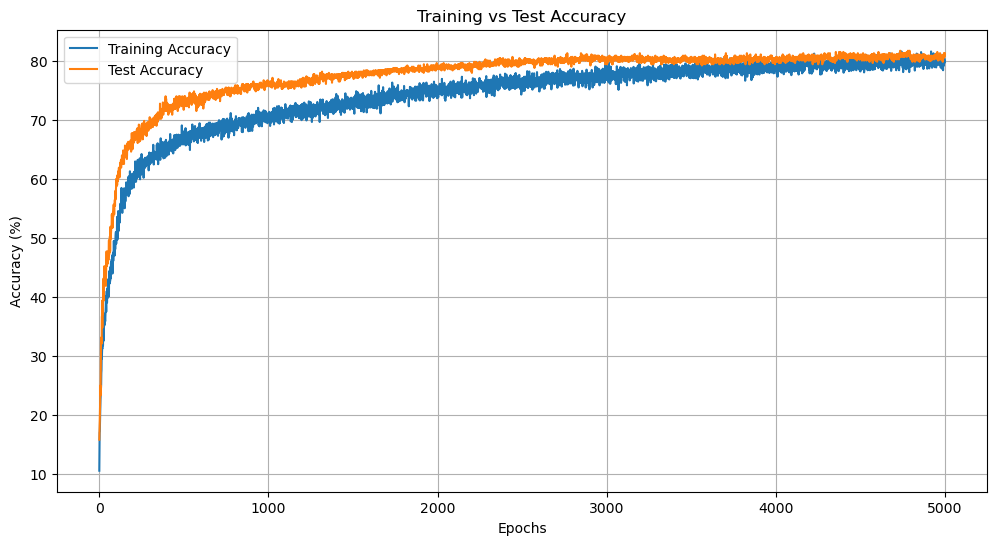

Max Accuracy: 81.66666666666667 at epoch 4737
Final Test Accuracy: 81.25%


81.25

In [25]:
# with torch.device(device):
#        trained_model = train_model(model, X_train, y_train, X_test, y_test)
#        evaluate_model(trained_model, X_test, y_test)
trained_model = train_model(model, X_train, y_train, X_test, y_test, epochs=5000, lr=1e-4) # epochs was 5000
evaluate_model(trained_model, X_test, y_test)

In [ ]:
# Split the data into training and test sets, ensuring 30 examples per label for the test set
train_data = pd.DataFrame()
test_data = pd.DataFrame()

In [ ]:
for label, group in data.groupby('label'):
    train, test = train_test_split(group, test_size=30, random_state=42)
    train_data = pd.concat([train_data, train])
    test_data = pd.concat([test_data, test])

In [ ]:
transient_lengths = []
for idx, row in data.iterrows():
    transient_lengths.append(len(row['transient']))
print(np.unique(transient_lengths, return_counts=True))

In [ ]:
# Separate the features (signal data) and labels for training and test sets
# X_train = train_data['signal']
X_train = train_data['transient']
y_train = train_data['label']
# X_test = test_data['signal']
X_test = test_data['transient']
y_test = test_data['label']

In [ ]:
print(y_train.value_counts())

In [ ]:
print(y_test.value_counts())

In [ ]:
# Ensure X_train is a DataFrame with one column, where each cell is a Series
X_train_df = pd.DataFrame({'signal': X_train})
X_test_df = pd.DataFrame({'signal': X_test})

In [ ]:
# Setup pipeline
bluetooth_pipeline = make_pipeline(
    MiniRocketMultivariateVariable(
        pad_value_short_series=-10.0, 
        random_state=42,
        reference_length='max',
        max_dilations_per_kernel=32,
        n_jobs=-1
    ),
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
)

In [ ]:
# Fit the pipeline
bluetooth_pipeline.fit(X_train_df, y_train)

In [ ]:
# Evaluate the pipeline
accuracy = bluetooth_pipeline.score(X_test_df, y_test)
print(f"Test Accuracy: {accuracy:.3f}")

In [ ]:
# Predict labels for the test set
y_pred = bluetooth_pipeline.predict(X_test_df)

# Create a DataFrame to compare true and predicted labels
results = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': y_pred
})

# Identify incorrect predictions
incorrect_predictions = results[results['True Label'] != results['Predicted Label']]

# Print incorrect predictions
print("Incorrect Predictions:")
print(incorrect_predictions)